<a href="https://colab.research.google.com/github/hackerpranavpandey/SOI_Mission_Mars_Terrain/blob/main/Train_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/'
images_path=path+'Mission_Mars'

In [ ]:
import os
os.listdir(images_path)

['train.csv', 'train_dataset', 'test_dataset', 'pred_resnet152.csv']

In [ ]:
import pandas as pd
df=pd.read_csv(images_path+'/train.csv')
df.head()

,File Name,Class
0,1.jpg,other
1,2.jpg,bright dune
2,3.jpg,other
3,4.jpg,crater
4,5.jpg,other


In [ ]:
df.iloc[:,1:].value_counts()

Class        
other            3651
crater           1062
bright dune       597
slope streak      335
swiss cheese      223
dark dune         216
spider             66
impact ejecta      51
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6201 entries, 0 to 6200
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  6201 non-null   object
 1   Class      6201 non-null   object
dtypes: object(2)
memory usage: 97.0+ KB


In [ ]:
images_path+='/train_dataset/'

In [ ]:
os.listdir(images_path)[:10]

['5664.jpg',
 '5659.jpg',
 '5672.jpg',
 '5686.jpg',
 '5662.jpg',
 '567.jpg',
 '5678.jpg',
 '5676.jpg',
 '5680.jpg',
 '5665.jpg']

In [ ]:
import cv2
labels=[]
images=[]
for image in os.listdir(images_path):
  image_array=cv2.imread(images_path+image,cv2.IMREAD_COLOR)
  images.append(image_array)
  label=int(image.split('.')[0])-1
  labels.append(label)

In [ ]:
for i in range(len(labels)):
  labels[i]=df.iloc[labels[i],1:][0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.shape(images),np.shape(labels)

((6201, 227, 227, 3), (6201,))

In [ ]:
print(images[0])

[[[127 127 127]
  [128 128 128]
  [127 127 127]
  ...
  [138 138 138]
  [131 131 131]
  [125 125 125]]

 [[129 129 129]
  [130 130 130]
  [130 130 130]
  ...
  [134 134 134]
  [129 129 129]
  [125 125 125]]

 [[131 131 131]
  [134 134 134]
  [136 136 136]
  ...
  [131 131 131]
  [128 128 128]
  [126 126 126]]

 ...

 [[129 129 129]
  [131 131 131]
  [131 131 131]
  ...
  [113 113 113]
  [110 110 110]
  [108 108 108]]

 [[128 128 128]
  [130 130 130]
  [131 131 131]
  ...
  [108 108 108]
  [102 102 102]
  [ 98  98  98]]

 [[128 128 128]
  [129 129 129]
  [130 130 130]
  ...
  [105 105 105]
  [ 95  95  95]
  [ 89  89  89]]]


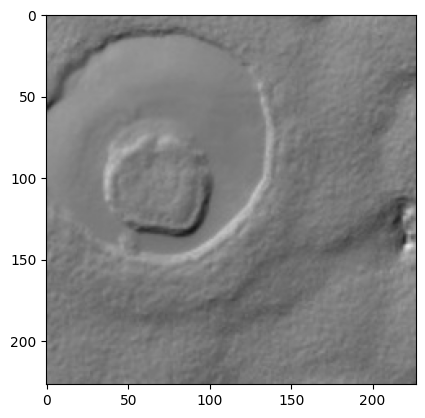

In [ ]:
plt.imshow(images[0])

In [ ]:
labels[0]

'swiss cheese'

In [ ]:
## now lets do some data augementation for images with less  number to decrease the model underfitting
def image_augmentation():
  t=len(images)
  for i in range(0,t):
    rotated_array_90=cv2.rotate(images[i], cv2.ROTATE_90_CLOCKWISE)
    rotate_180=cv2.rotate(images[i], cv2.ROTATE_180)
    rotated_array_270 = cv2.rotate(images[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
    if labels[i]=='crater':
      images.append(rotate_180)
      labels.append(labels[i])
    elif labels[i]=="bright dune" or labels[i]=="slope streak" or labels[i]=="swiss cheese" or labels[i]=="dark dune":
      images.append(rotated_array_90)
      labels.append(labels[i])
      images.append(rotate_180)
      labels.append(labels[i])
    elif labels[i]=="spider" or labels[i]=="impact ejecta":
      images.append(rotated_array_90)
      labels.append(labels[i])
      images.append(rotate_180)
      labels.append(labels[i])
      images.append(rotated_array_270)
      labels.append(labels[i])
image_augmentation()

In [ ]:
np.shape(images),np.shape(labels)

((10356, 227, 227, 3), (10356,))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(labels)
encoded_mapping = {label: encoded_value for label, encoded_value in zip(target,labels)}
print(encoded_mapping)

{7: 'swiss cheese', 4: 'other', 0: 'bright dune', 1: 'crater', 3: 'impact ejecta', 2: 'dark dune', 5: 'slope streak', 6: 'spider'}


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
images = np.array(images)
labels = np.array(labels)
train_images, val_images, train_labels, val_labels = train_test_split(images, target, test_size=0.2, random_state=42)

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(unique, counts)

[0 1 2 3 4 5 6 7] [1436 1679  524  174 2920  800  218  533]


In [ ]:
unique,counts=np.unique(val_labels,return_counts=True)
print(unique,counts)

[0 1 2 3 4 5 6 7] [355 445 124  30 731 205  46 136]


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from torchvision import transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   ## har 3 channel ke liye R,G,B these mean values are used for imageNet dataset
                                     ])

In [ ]:
from torch.utils.data import DataLoader
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for image,label in train_dataset:
  print(image)
  print(label)
  break

tensor([[[0.8961, 0.9132, 0.9303,  ..., 0.5536, 0.5878, 0.6049],
         [0.9132, 0.9132, 0.9303,  ..., 0.5536, 0.5878, 0.6221],
         [0.9132, 0.9132, 0.9132,  ..., 0.5878, 0.6221, 0.6563],
         ...,
         [0.5364, 0.5364, 0.5193,  ..., 0.4851, 0.4851, 0.5022],
         [0.5364, 0.5193, 0.5022,  ..., 0.4851, 0.4851, 0.5022],
         [0.5364, 0.5193, 0.4851,  ..., 0.4851, 0.4851, 0.4851]],

        [[1.0455, 1.0630, 1.0805,  ..., 0.6954, 0.7304, 0.7479],
         [1.0630, 1.0630, 1.0805,  ..., 0.6954, 0.7304, 0.7654],
         [1.0630, 1.0630, 1.0630,  ..., 0.7304, 0.7654, 0.8004],
         ...,
         [0.6779, 0.6779, 0.6604,  ..., 0.6254, 0.6254, 0.6429],
         [0.6779, 0.6604, 0.6429,  ..., 0.6254, 0.6254, 0.6429],
         [0.6779, 0.6604, 0.6254,  ..., 0.6254, 0.6254, 0.6254]],

        [[1.2631, 1.2805, 1.2980,  ..., 0.9145, 0.9494, 0.9668],
         [1.2805, 1.2805, 1.2980,  ..., 0.9145, 0.9494, 0.9842],
         [1.2805, 1.2805, 1.2805,  ..., 0.9494, 0.9842, 1.

In [ ]:
from torchvision import models
import torch.nn as nn
num_classes = len(np.unique(labels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vision_transformer.vit_b_16(pretrained=True)
num_ftrs = model.heads.head.in_features
model.heads.head = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def patching(image,patch_num):
  n,c,h,w=image.shape


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
save_path = '/content/drive/MyDrive/model.pth'
num_classes=8
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train=[]
        all_pred_train=[]
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_labels_train.extend(labels.cpu().numpy())
            all_pred_train.extend(predicted.cpu().numpy())
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        all_labels_val=[]
        all_pred_val=[]
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                max_value,predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_labels_val.extend(labels.cpu().numpy())
                all_pred_val.extend(predicted.cpu().numpy())
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        train_conf_matrix=confusion_matrix(all_labels_train,all_pred_train,labels=list(range(num_classes)))
        test_conf_matrix=confusion_matrix(all_labels_val,all_pred_val,labels=list(range(num_classes)))
        if epoch==39:
          sns.heatmap(train_conf_matrix,annot=True,fmt='d',cmap="Blues",xticklabels=list(range(num_classes)),yticklabels=list(range(num_classes)))
          plt.title('confusion matrix')
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.show()
          sns.heatmap(test_conf_matrix,annot=True,fmt='d',cmap="Blues",xticklabels=list(range(num_classes)),yticklabels=list(range(num_classes)))
          plt.title('confusion matrix')
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.show()
          torch.save(model.state_dict(),save_path)
          break
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)

Epoch 1/40, Train Loss: 1.4200, Train Accuracy: 46.64%, Val Loss: 1.2122, Val Accuracy: 53.96%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
